# Zoopla - London House Price

#### Data Source: https://www.zoopla.co.uk/for-sale/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import os

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

In [2]:
os.listdir('datasets')

['zoopla.csv']

In [3]:
# Read dataset
df = pd.read_csv('datasets/zoopla.csv')
df.head(3)

,id,agent_name,condition,distance_to_charing_cross,distance_to_closest_airport,distance_to_closest_dlr_or_underground_station,distance_to_closest_national_rail_station,distance_to_closest_primary_school,latitude,longitude,n_bathrooms,n_bedrooms,n_reception_rooms,postcode,price,price_qualifier,property_type,size_sqft,status,tenure
0,893588,Hamptons International,pre-owned,2.043523,10.497350,0.177325,0.351489,0.260448,51.510722,-0.095667,2.0,2.0,1.0,EC4V 3EJ,1050000,NaN,flat,NaN,for_sale,leasehold
1,939056,Hamptons International,pre-owned,2.305455,10.202792,0.504113,0.411439,0.407471,51.506942,-0.091646,4.0,3.0,1.0,SE1 9DW,3950000,NaN,flat,NaN,for_sale,leasehold
2,1686433,Jorgensen Turner,pre-owned,7.224687,16.511607,0.363300,0.852112,0.243911,51.508411,-0.228859,NaN,3.0,NaN,W12 7EY,780000,NaN,flat,NaN,for_sale,freehold


# Exploratory Data Analysis (EDA)

In [4]:
df.shape

(36213, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36213 entries, 0 to 36212
Data columns (total 20 columns):
id                                                36213 non-null int64
agent_name                                        36213 non-null object
condition                                         36213 non-null object
distance_to_charing_cross                         36213 non-null float64
distance_to_closest_airport                       36213 non-null float64
distance_to_closest_dlr_or_underground_station    33857 non-null float64
distance_to_closest_national_rail_station         34756 non-null float64
distance_to_closest_primary_school                36213 non-null float64
latitude                                          36213 non-null float64
longitude                                         36213 non-null float64
n_bathrooms                                       31812 non-null float64
n_bedrooms                                        34929 non-null float64
n_reception_rooms  

Price is our target variable.
We will explore the price around other features such as number of bedrooms, bathrooms, size, conditions, distances etc..

In [6]:
df_price = df['price']

In [7]:
df_price.describe()

count    3.621300e+04
mean     9.773267e+05
std      1.420686e+06
min      8.250000e+03
25%      4.500000e+05
50%      6.300000e+05
75%      9.950000e+05
max      8.000000e+07
Name: price, dtype: float64

C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


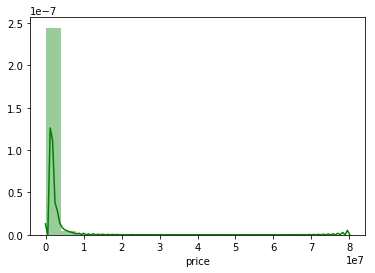

In [8]:
# Create displot 
sns.distplot(df['price'], bins=20, color = 'green')

Firstly, we can see the distribution of price doesn't look normal. It looks like we have many outliers. In order to find these outliers, we create more charts to see which one they are.

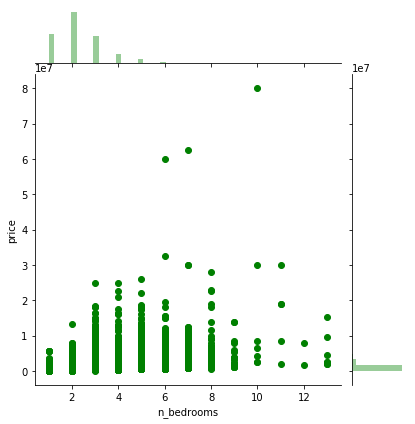

In [9]:
sns.jointplot(x='n_bedrooms',y='price',data=df, kind ='scatter', color='green')

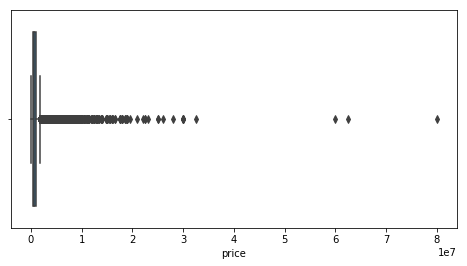

In [10]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['price'])

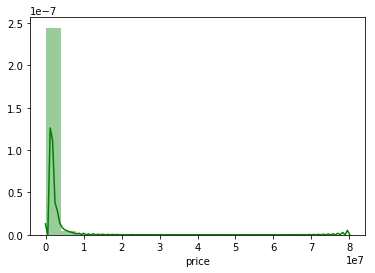

In [11]:
sns.distplot(df['price'], bins=20, color = 'green')

## Data preprocessing

In [12]:
# Check null values 
df.isnull().sum()

id                                                    0
agent_name                                            0
condition                                             0
distance_to_charing_cross                             0
distance_to_closest_airport                           0
distance_to_closest_dlr_or_underground_station     2356
distance_to_closest_national_rail_station          1457
distance_to_closest_primary_school                    0
latitude                                              0
longitude                                             0
n_bathrooms                                        4401
n_bedrooms                                         1284
n_reception_rooms                                  7207
postcode                                              0
price                                                 0
price_qualifier                                   28507
property_type                                         0
size_sqft                                       

We can see the features that has null values. This may affect our prediction later on. Firstly we need to clean the data.

In [13]:
df['price_qualifier'].unique()

array([nan, 'guide_price', 'offers_over', 'offers_in_region_of', 'from',
       'fixed_price'], dtype=object)

In [14]:
df['tenure'].unique()

array(['leasehold', 'freehold', 'share_of_freehold', nan], dtype=object)

As tenure and price_qualifier have more than 50% of null values, we can drop it from the df dataset

In [15]:
df.drop(['tenure','price_qualifier'], axis=1, inplace = True)

In [16]:
print(df['n_bedrooms'].mean())
print(df['n_bathrooms'].mean())
print(df['n_reception_rooms'].mean())



2.3337341464112913
1.5705708537658745
1.2120940495069985


In [17]:
df['n_bathrooms'].fillna(1, inplace=True)
df['n_bedrooms'].fillna(2, inplace=True)
df['n_reception_rooms'].fillna(1, inplace=True)
df['distance_to_closest_national_rail_station'].fillna(df['distance_to_closest_national_rail_station'].mean(), inplace=True)
df['distance_to_closest_dlr_or_underground_station'].fillna(df['distance_to_closest_dlr_or_underground_station'].mean(), inplace=True)

In [18]:
df['size_sqft'].fillna(df['size_sqft'].mean(), inplace=True)

# check again
df['size_sqft'].isnull().sum()

0

In [19]:
df=df[df['n_bedrooms'] < 8]
df['n_bedrooms'].unique()

array([2., 3., 1., 4., 5., 6., 7.])

In [20]:
df=df[df['n_bathrooms'] < 6]
df['n_bathrooms'].unique()

array([2., 4., 1., 5., 3.])

In [21]:
df.isna().sum()

id                                                0
agent_name                                        0
condition                                         0
distance_to_charing_cross                         0
distance_to_closest_airport                       0
distance_to_closest_dlr_or_underground_station    0
distance_to_closest_national_rail_station         0
distance_to_closest_primary_school                0
latitude                                          0
longitude                                         0
n_bathrooms                                       0
n_bedrooms                                        0
n_reception_rooms                                 0
postcode                                          0
price                                             0
property_type                                     0
size_sqft                                         0
status                                            0
dtype: int64

# Remove outlier

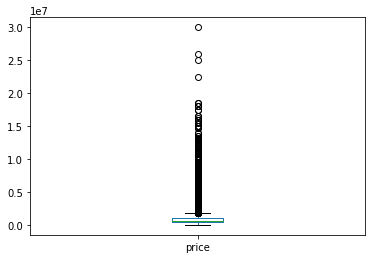

In [22]:
df['price'].plot.box()

We can see there are many outliers of our target variable. 
Next step we can try to remove the outliers by creating the function below

In [23]:
def remove_outlier_mod(df, col, q):
  '''Outliers removal
  Modified: q is the lower quartile, it will keep
  data between q and (1-q)
  ''' 
  q1 = df[col].quantile(q)
  q3 = df[col].quantile(1-q)
  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)
  out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
  return out_df

df = remove_outlier_mod(df,"price", 0.15)

In [24]:
df.shape

(34478, 18)

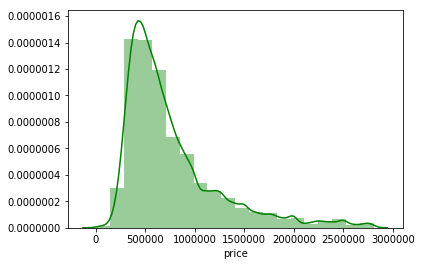

In [25]:
# Create displot 
sns.distplot(df['price'], bins=20, color = 'green')

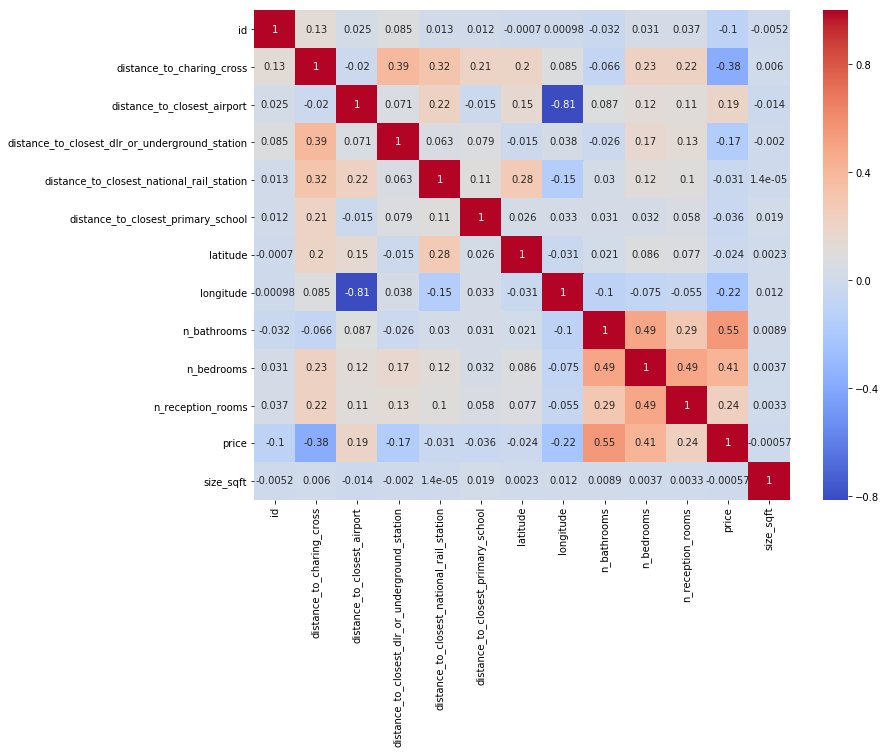

In [26]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

- Based on the heatmap, we can see that n_bedrooms and n_bathrooms are high correlated to each other, and they both are strong positive correlation with target variable (price). So, we can focus on n_bedrooms as one of the top featues.
- Distance to charring cross has strong negative correlation with price.
- For the linear regress model, I will choose two top features (distance_to_charringcross, and n_bedrooms).

In [27]:
df.columns

Index(['id', 'agent_name', 'condition', 'distance_to_charing_cross',
       'distance_to_closest_airport',
       'distance_to_closest_dlr_or_underground_station',
       'distance_to_closest_national_rail_station',
       'distance_to_closest_primary_school', 'latitude', 'longitude',
       'n_bathrooms', 'n_bedrooms', 'n_reception_rooms', 'postcode', 'price',
       'property_type', 'size_sqft', 'status'],
      dtype='object')

In [28]:
df_full = df[[ 'agent_name', 'condition', 'distance_to_charing_cross',
       'distance_to_closest_airport',
       'distance_to_closest_dlr_or_underground_station',
       'distance_to_closest_national_rail_station',
       'distance_to_closest_primary_school', 'latitude', 'longitude',
       'n_bathrooms', 'n_bedrooms', 'n_reception_rooms', 'postcode', 'price',
       'property_type', 'size_sqft', 'status']]

In [29]:
df_reduced = df[['n_bedrooms', 'distance_to_charing_cross','price']]

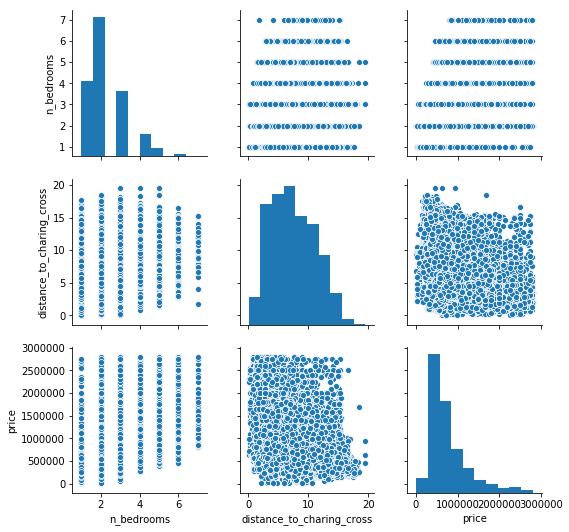

In [30]:
sns.pairplot(df_reduced)

# Linear regression model 

In [31]:
# Create a linear regresson model for reduced dataset
formula = 'price ~ ' + ' + '.join(x for x in df_reduced.columns if x != 'price')
model_reduced = smf.ols(formula, data=df_reduced).fit()

In [32]:
model_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                 1.179e+04
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:18:55   Log-Likelihood:            -4.9109e+05
No. Observations:               34478   AIC:                         9.822e+05
Df Residuals:                   34475   BIC:                         9.822e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  7.189e+05   5727.192    125.528      0.000    7.08e+05     7.3e+05
n_bedrooms                 2.422e+05   1962.209    123.427      0.000    2.38e+05    2.46e+05
distance_to_charing_cross -6.664e+04    569.797   -116.950      0.000   -6.78e+04   -6.55e+04
==============================================================================
Omnibus:                     9295.684   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29263.740
Skew:                           1.380   Prob(JB):                         0.00
Kurtosis:                       6.571   Cond. No.                         25.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

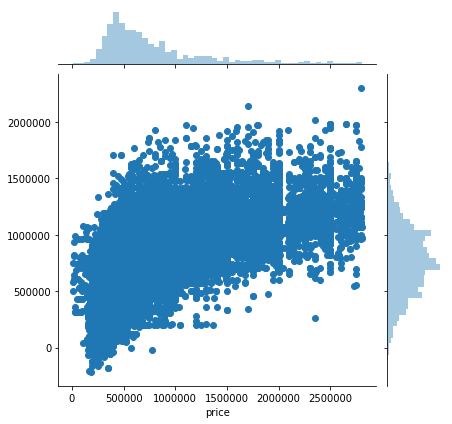

In [33]:
sns.jointplot(df_reduced['price'], model_reduced.fittedvalues)

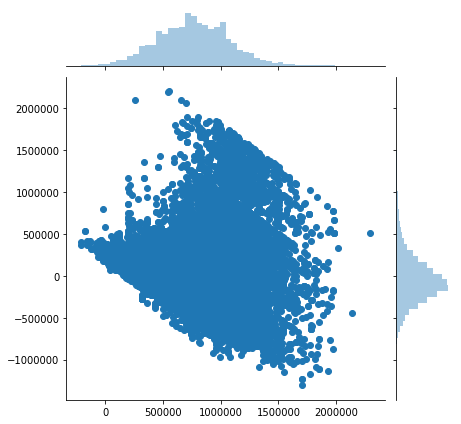

In [34]:
sns.jointplot(model_reduced.fittedvalues, model_reduced.resid)

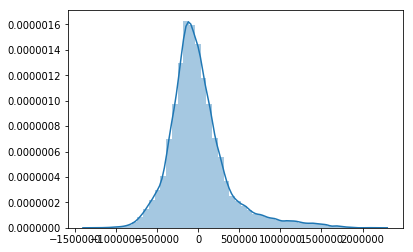

In [35]:
sns.distplot(model_reduced.resid)

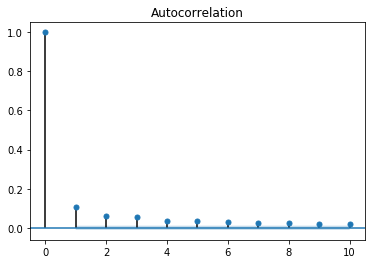

In [36]:
plot_acf(model_reduced.resid, lags=10);

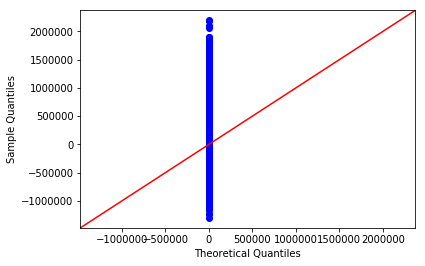

In [80]:
qqplot(model_reduced.resid, line='45');

The blue line is not aligned to 45 line. Try to plot with resid_pearson

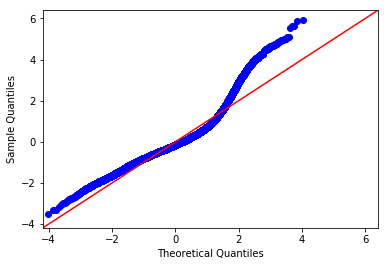

In [37]:
qqplot(model_reduced.resid_pearson, line='45');

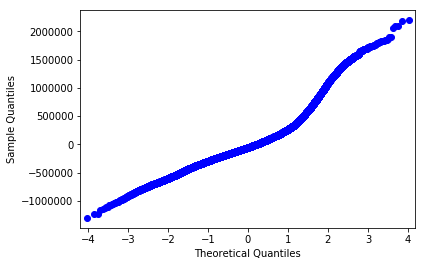

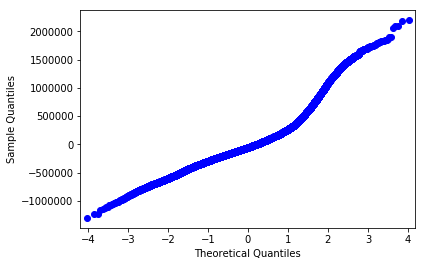

In [38]:
qqplot(model_reduced.resid) # line='45');